In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from keras.metrics import MeanIoU
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, UpSampling2D, concatenate, Activation, multiply, Reshape,BatchNormalization
from keras.layers import GlobalAveragePooling2D, Reshape
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping

2024-12-24 18:35:57.806309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 18:35:57.806405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 18:35:57.951686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data(image_filenames, mask_filenames, image_dir, mask_dir, image_size=(512, 512)):
    image_list, mask_list = [], []
    for img_file, mask_file in zip(image_filenames, mask_filenames):
        if img_file.endswith(".png") and mask_file.endswith(".png"):
            image = cv2.imread(os.path.join(image_dir, img_file), cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, image_size)
            image = image / 255.0  # Normalize to [0, 1]
            image = np.expand_dims(image, axis=-1)  # Add channel dimension
            image_list.append(image)
            
            mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, image_size)
            mask = mask / 255.0  # Normalize to [0, 1]
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            mask_list.append(mask)
    return np.array(image_list), np.array(mask_list)


In [3]:
# Define paths to your image and mask directories
image_dir = '/kaggle/input/fives-a-fundus-image/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original/'
mask_dir = '/kaggle/input/fives-a-fundus-image/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth/'

# Get list of image and mask filenames
image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

# Sort filenames to ensure corresponding images and masks match
image_filenames.sort()
mask_filenames.sort()
# Load images and masks
images, masks = load_data(image_filenames, mask_filenames, image_dir, mask_dir)


In [4]:
# Define paths to your image and mask directories
image_dir = '/kaggle/input/fives-a-fundus-image/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/'
mask_dir = '/kaggle/input/fives-a-fundus-image/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/'

# Get list of image and mask filenames
image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

# Sort filenames to ensure corresponding images and masks match
image_filenames.sort()
mask_filenames.sort()
# Load images and masks
Images_test, Masks_test = load_data(image_filenames, mask_filenames, image_dir, mask_dir)

In [5]:
images =np.array(images)
masks =np.array(masks)
Images_test =np.array(Images_test)
Masks_test =np.array(Masks_test)

images_val, images_test, masks_val, masks_test = train_test_split(Images_test, Masks_test, test_size=0.5, random_state=42)

# Print shapes to verify
print("Training images shape:", images.shape)
print("Training masks shape:", masks.shape)
print("test images shape:", images_test.shape)
print("test masks shape:", masks_test.shape)
print("validation images shape:", images_val.shape)
print("validation masks shape:", masks_val.shape)
# Ensure your images and masks are 4D tensors with consistent shapes

images = tf.expand_dims(images, axis=-1)  # If your images are (batch, height, width)
masks = tf.expand_dims(masks, axis=-1)    # If your masks are (batch, height, width)

images_test = tf.expand_dims(images_test, axis=-1)
masks_test = tf.expand_dims(masks_test, axis=-1)

images_val = tf.expand_dims(images_val, axis=-1)
masks_val = tf.expand_dims(masks_val, axis=-1)

Training images shape: (600, 512, 512, 1)
Training masks shape: (600, 512, 512, 1)
test images shape: (100, 512, 512, 1)
test masks shape: (100, 512, 512, 1)
validation images shape: (100, 512, 512, 1)
validation masks shape: (100, 512, 512, 1)


In [6]:
def dice_loss(y_true, y_pred):
    smooth = 1.0  # To avoid division by zero
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Define PSNR metric
def psnr(y_true, y_pred):
    # Ensure y_true and y_pred have the same shape
    y_true = tf.ensure_shape(y_true, y_pred.shape)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

stop_callback=EarlyStopping(monitor='val_accuracy',restore_best_weights=True,verbose=1 , mode='max',patience=50,start_from_epoch=0)

# Custom SSIM metric
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model

In [8]:
def pspnet(input_shape=(512, 512, 1)):
    inputs = tf.keras.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    pool2 = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(x)
    pool1 = tf.keras.layers.UpSampling2D(size=(2, 2))(pool1)
    pool2 = tf.keras.layers.UpSampling2D(size=(4, 4))(pool2)
    concat = tf.keras.layers.concatenate([x, pool1, pool2], axis=-1)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(concat)
    model = tf.keras.Model(inputs, outputs)
    return model


In [9]:
psp = pspnet(input_shape=(512, 512, 1))
print("Model output shape:", psp.output_shape)

Model output shape: (None, 512, 512, 1)


In [10]:
print("Images shape:", images.shape)  # Should be (batch_size, 512, 512, 1)
print("Masks shape:", masks.shape)    # Should be (batch_size, 512, 512, 1)


Images shape: (600, 512, 512, 1, 1)
Masks shape: (600, 512, 512, 1, 1)


In [11]:
# Ensure tensors have the correct shape by removing all unnecessary dimensions first
images = tf.squeeze(images)  # Removes all dimensions of size 1
masks = tf.squeeze(masks)
images_val = tf.squeeze(images_val)
masks_val = tf.squeeze(masks_val)
images_test = tf.squeeze(images_test)
masks_test = tf.squeeze(masks_test)

# Add back the single channel dimension to ensure (batch_size, 512, 512, 1)
images = tf.expand_dims(images, axis=-1)
masks = tf.expand_dims(masks, axis=-1)
images_val = tf.expand_dims(images_val, axis=-1)
masks_val = tf.expand_dims(masks_val, axis=-1)
images_test = tf.expand_dims(images_test, axis=-1)
masks_test = tf.expand_dims(masks_test, axis=-1)

# Verify the new shapes
print("Images shape:", images.shape)  # Should be (batch_size, 512, 512, 1)
print("Masks shape:", masks.shape)    # Should be (batch_size, 512, 512, 1)


Images shape: (600, 512, 512, 1)
Masks shape: (600, 512, 512, 1)


In [12]:
# Recompile with the appropriate metrics
psp.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy', 
                         tf.keras.metrics.Precision(), 
                         tf.keras.metrics.MeanIoU(num_classes=2)])



In [13]:
# Train the model
history = psp.fit(images, masks, validation_data=(images_val, masks_val), 
                      epochs=30, batch_size=1, verbose=1)


Epoch 1/30


2024-12-24 18:38:46.709832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262144: 1.24674, expected 0.706489
2024-12-24 18:38:46.709885: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262145: 2.29621, expected 1.75596
2024-12-24 18:38:46.709895: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262146: 2.24082, expected 1.70057
2024-12-24 18:38:46.709903: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262147: 1.8087, expected 1.26845
2024-12-24 18:38:46.709911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262148: 2.13502, expected 1.59477
2024-12-24 18:38:46.709919: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262149: 2.59674, expected 2.05649
2024-12-24 18:38:46.709940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262150: 2.16053, expected 1.62028
2024-12-24 18:38:46.

 18/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9012 - loss: 0.6703 - mean_io_u: 0.4632 - precision: 0.0256

I0000 00:00:1735065528.505634     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9183 - loss: 0.3747 - mean_io_u: 0.3859 - precision: 0.0254 - val_accuracy: 0.9237 - val_loss: 0.2379 - val_mean_io_u: 0.4551 - val_precision: 0.0000e+00
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9186 - loss: 0.2479 - mean_io_u: 0.3857 - precision: 0.0000e+00 - val_accuracy: 0.9237 - val_loss: 0.2321 - val_mean_io_u: 0.4551 - val_precision: 0.0000e+00
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9192 - loss: 0.2425 - mean_io_u: 0.3855 - precision: 0.0000e+00 - val_accuracy: 0.9237 - val_loss: 0.2318 - val_mean_io_u: 0.4551 - val_precision: 0.0000e+00
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9184 - loss: 0.2438 - mean_io_u: 0.3848 - precision: 0.0000e+00 - val_accuracy: 0.9237 - val_loss: 0.2312 - val_mean_io_u: 0.4551 - val_precision: 0.0000e+00
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9186 - loss: 0.2428 - mean_io_u: 0.3854 - preci

In [14]:
psp.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', MeanIoU(num_classes=2)])  # Replace 'mean_io_u' with your actual IoU metric


In [15]:
test_loss, test_accuracy, test_miou = psp.evaluate(images_test, masks_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Mean IoU: {test_miou}")


2024-12-24 18:41:47.463630: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,512,512]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-12-24 18:41:50.593864: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.79427, expected 0.794404
2024-12-24 18:41:50.593916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.55447, expected 1.55461
2024-12-24 18:41:50.593936: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.37298, expected 1.37312
2024-12-24 18:41:50.593945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] 

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9198 - loss: 0.2203 - mean_io_u_1: 0.4625

2024-12-24 18:42:02.588294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 0.925107, expected 0.534345
2024-12-24 18:42:02.588358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.48528, expected 1.09452
2024-12-24 18:42:02.588368: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.1634, expected 0.772635
2024-12-24 18:42:02.588376: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.71021, expected 1.31945
2024-12-24 18:42:02.588384: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.49143, expected 1.10067
2024-12-24 18:42:02.588392: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.15516, expected 0.764399
2024-12-24 18:42:02.588400: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.81655, expected 1.42579
2024-12-24 18:42:02.588408: E external/local_xla/xla

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 918ms/step - accuracy: 0.9204 - loss: 0.2195 - mean_io_u_1: 0.4588
Test Loss: 0.21844430267810822
Test Accuracy: 0.9211326837539673
Mean IoU: 0.45329636335372925


In [16]:
psp.save("psp_segmentation_model.h5")

In [17]:
psp.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 512, 512,  │          0 │ average_pooling2… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 512, 512,  │          0 │ average_pooling2… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512, 512,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 192)              │            │ up_sampling2d[0]… │
│                     │                   │            │ up_sampling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │        193 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


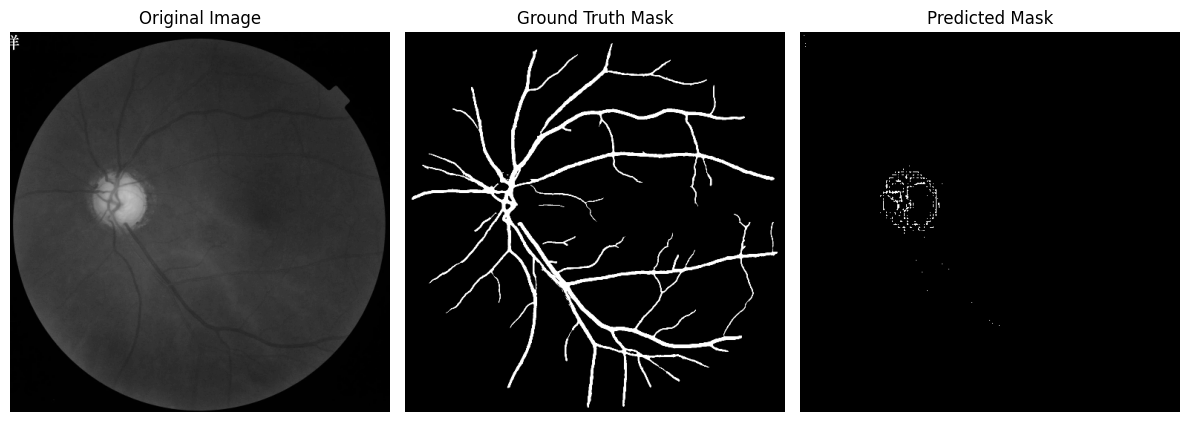

In [18]:
import matplotlib.pyplot as plt

# Assuming `images_test` is the test set, `masks_test` is the ground truth, and `deeplab` is the trained model.

# Get the third test sample
sample_index = 2
original_image = images_test[sample_index]
ground_truth_mask = masks_test[sample_index]
predicted_mask = psp.predict(tf.expand_dims(original_image, axis=0))[0]  # Predict for the sample
predicted_mask = (predicted_mask > 0.5).astype("float32")  # Apply threshold for binary mask

# Plot the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(tf.squeeze(original_image), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(tf.squeeze(ground_truth_mask), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(tf.squeeze(predicted_mask), cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
